In [2]:
from scipy.cluster.hierarchy import ward, dendrogram, linkage
from scipy.spatial.distance import pdist

from knn_chain import knn_chain, get_top_k

import numpy as np
import time

import pstats, cProfile
import pyximport
pyximport.install()

(None, <pyximport._pyximport3.PyxImportMetaFinder at 0x7f980c2064a0>)

## Data

In [ ]:
def generate_multivariate_gaussian_data(num_samples, num_features, num_distributions):
    """
    Generate a massive multidimensional, multivariate Gaussian dataset.

    Parameters:
    - num_samples: Total number of samples to generate.
    - num_features: Number of features (dimensions) for each sample.
    - num_distributions: Number of different Gaussian distributions.

    Returns:
    - data: Generated dataset of shape (num_samples, num_features).
    """
    data = []
    samples_per_distribution = num_samples // num_distributions

    for i in range(num_distributions):
        mean = np.random.rand(num_features) * 100
        cov = np.random.rand(num_features, num_features)
        cov = np.dot(cov, cov.transpose())

        distribution_data = np.random.multivariate_normal(mean, cov, samples_per_distribution)
        data.append(distribution_data)

    data = np.vstack(data)
    return data

In [ ]:
num_samples = 1000
num_features = 10
num_distributions = 4

X = list(generate_multivariate_gaussian_data(num_samples, num_features, num_distributions))

## Profiling

### 1. get_top_k()

In [6]:
# np.savetxt("largeX", X)
X = list(np.loadtxt("largeX"))
print(f"shape of X: {len(X), len(X[0])}")

shape of X: (10000, 100)


In [5]:
for i in range(50):
    cProfile.runctx("get_top_k(i = 0, size = np.ones(shape=len(X)), pos = X, active=set([i for i in range(len(X))]), k = 3)", globals(), locals(), "Profile.prof")

In [8]:
avg = 0.0

for i in range(50):
    cProfile.runctx("get_top_k(i = 0, size = np.ones(shape=len(X)), pos = X, active=set([i for i in range(len(X))]), k = 3)", globals(), locals(), "Profile.prof")
    s = pstats.Stats("Profile.prof")
    avg += s.strip_dirs().sort_stats("time").total_tt
    
print(f"avg = {avg/50}")
s.strip_dirs().sort_stats("time").print_stats()
#0.011853878739999999

avg = 0.0119096234
Mon Jun 10 15:12:14 2024    Profile.prof

         20018 function calls (20017 primitive calls) in 0.012 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     9999    0.004    0.000    0.007    0.000 py_knn_chain_copy.pyx:22(ward)
     9999    0.004    0.000    0.004    0.000 py_knn_chain_copy.pyx:9(euclidean_norm_squared)
      2/1    0.003    0.002    0.011    0.011 py_knn_chain_copy.pyx:28(get_top_k)
        1    0.001    0.001    0.001    0.001 {method 'argsort' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.000    0.000 <string>:1(<listcomp>)
        1    0.000    0.000    0.012    0.012 <string>:1(<module>)
        1    0.000    0.000    0.012    0.012 {built-in method builtins.exec}
        2    0.000    0.000    0.001    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1    0.000    0.000    0.001    0.001 fromnumeric.py:51(_wrapfunc)
        1    

### 2. knn_chain()

In [12]:
# np.savetxt("X", X)
X = list(np.loadtxt("X"))
print(f"shape of X: {len(X), len(X[0])}")

shape of X: (1000, 10)


In [8]:
for i in range(3):
    cProfile.runctx("knn_chain(X, k = 3)", globals(), locals(), "Profile.prof")

In [9]:
avg = 0.0

for i in range(3):
    cProfile.runctx("knn_chain(X, k = 3)", globals(), locals(), "Profile.prof")
    s = pstats.Stats("Profile.prof")
    avg += s.strip_dirs().sort_stats("time").total_tt
    
print(f"avg = {avg/3}")
s.strip_dirs().sort_stats("time").print_stats()
#1.5503262113333334

avg = 1.5346258759999998
Mon Jun 10 15:24:57 2024    Profile.prof

         2176039 function calls (2176038 primitive calls) in 1.522 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1076618    0.705    0.000    1.072    0.000 py_knn_chain_copy.pyx:22(ward)
  1076618    0.367    0.000    0.367    0.000 py_knn_chain_copy.pyx:9(euclidean_norm_squared)
     2131    0.292    0.000    1.496    0.001 py_knn_chain_copy.pyx:28(get_top_k)
     2131    0.129    0.000    0.129    0.000 {method 'argsort' of 'numpy.ndarray' objects}
      2/1    0.019    0.009    1.521    1.521 py_knn_chain_copy.pyx:46(py_knn_chain_c)
     2698    0.002    0.000    0.134    0.000 fromnumeric.py:51(_wrapfunc)
     2131    0.001    0.000    0.134    0.000 <__array_function__ internals>:177(argsort)
     2131    0.001    0.000    0.132    0.000 fromnumeric.py:1038(argsort)
     2698    0.001    0.000    0.137    0.000 {built-in method numpy.core._multiarr

## Comparison

In [16]:
# WIP
# get the start time
st = time.process_time()
########## FIX 
A = knn_chain(X, k = 3)
##########
# get the end time
et = time.process_time()
# get execution time
res = et - st
print('CPU Execution time:', res, 'seconds')

CPU Execution time: 0.6059273590000007 seconds


In [14]:
# SciPy implementation
# get the start time
st = time.process_time()
########## FIX 
y = pdist(X) 
Z = ward(y)
##########
# get the end time
et = time.process_time()
# get execution time
res = et - st
print('CPU Execution time:', res, 'seconds')
# dendrogram(Z);

CPU Execution time: 0.012507067999999677 seconds


## Dendrogram comparison

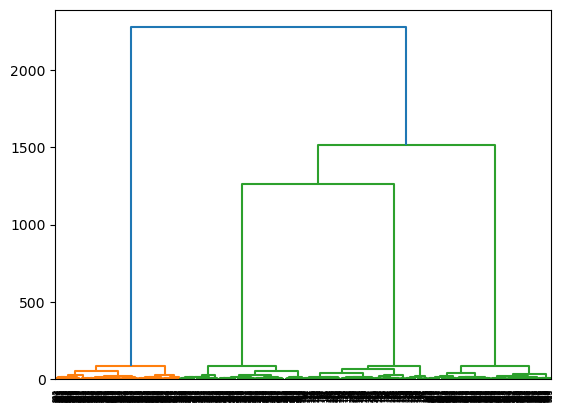

In [18]:
dendrogram(A);

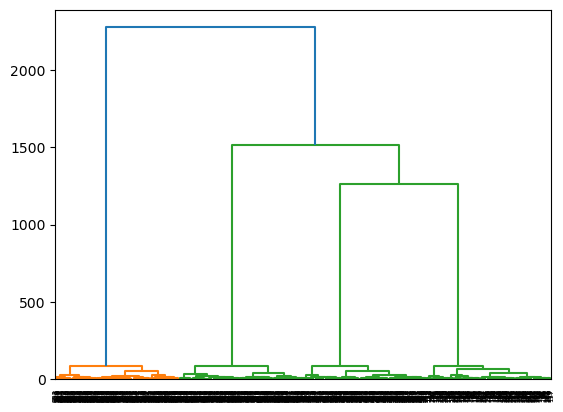

In [17]:
dendrogram(Z);